# In this notebook I will present my models which used for predictions

In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import statsmodels.api as sm
from collections import Counter
from imblearn.under_sampling import RandomUnderSampler

In [2]:
df = pd.read_csv('../creditcard.csv')

In [3]:
X = df.iloc[:, :-1]
y = df['Class']

In [4]:
und = RandomUnderSampler()
X_und, y_und = und.fit_resample(X, y)

In [5]:
Counter(y_und)

Counter({0: 492, 1: 492})

In [6]:
# Lets concat undersampled X and y
df_und = pd.concat([X_und, y_und], axis=1)
df_und.head()

,Time,V1,V2,V3,V4,V5,V6,V7,V8,V9,...,V21,V22,V23,V24,V25,V26,V27,V28,Amount,Class
0,81948.0,0.973589,-1.269750,1.300659,-0.453822,-1.988949,-0.226574,-1.133699,0.114741,-0.512646,...,0.005717,0.168942,-0.060069,0.581269,-0.098380,0.867877,-0.016822,0.049286,161.50,0
1,78980.0,-0.851823,1.446070,0.679759,0.007973,0.617801,-1.210695,1.369637,-0.442985,-0.466060,...,0.130170,0.471780,-0.215118,0.402875,-0.109756,-0.629885,-0.725665,-0.351324,2.99,0
2,39135.0,-1.290963,1.645203,0.408415,-0.316769,-0.302853,-0.234100,-0.167823,1.015001,-0.704536,...,-0.179895,-0.699234,-0.017346,-0.528842,-0.023764,0.115393,0.114109,0.036554,1.98,0
3,146600.0,-1.809266,-1.411973,1.393529,-0.735132,1.583143,-0.579496,-1.063889,0.597725,0.436892,...,0.430636,0.472094,0.276116,0.158468,-0.363882,0.363422,0.024769,0.205816,79.63,0
4,35170.0,-2.147159,1.910549,0.236852,-0.827965,-0.562288,0.182930,-0.557872,1.637837,-0.498152,...,-0.009958,-0.053458,0.130447,-0.246296,-0.197271,0.348126,0.170421,0.098211,1.00,0


## Lets build our first Pipeline

In [7]:
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import GradientBoostingClassifier
from catboost import CatBoostClassifier
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC
from xgboost import XGBClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.neighbors import KNeighborsClassifier
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from sklearn.metrics import roc_auc_score, f1_score, recall_score
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from lightgbm import LGBMClassifier
from sklearn.ensemble import BaggingClassifier

In [8]:
algos = {
    'DecisionTreeClassifier' : DecisionTreeClassifier(),
    'KNeighborsClassifier': KNeighborsClassifier(),
    'GaussianNB' : GaussianNB(),
    'LogisticRegression' : LogisticRegression(max_iter=200),
#     'BaggingClassifier' : BaggingClassifier(base_estimator=DecisionTreeClassifier(), n_estimators=50)
}

In [9]:
X_train, X_test, y_train, y_test = train_test_split(X_und, y_und)

In [10]:
for name, classifier in algos.items():
    pipeline = Pipeline(steps=[
        ('classifier', classifier)
    ])
    pipeline.fit(X_train, y_train)
    y_predicted=pipeline.predict_proba(X_test)
    print(name,'ROC SCORE', roc_auc_score(y_test, y_predicted[:, 1]))

DecisionTreeClassifier ROC SCORE 0.8954530368403585
KNeighborsClassifier ROC SCORE 0.6730833056754065
GaussianNB ROC SCORE 0.9770992366412214
LogisticRegression ROC SCORE 0.9806837039495518


### As we can see Gaussian Naive Bayes along side with Logistic regression performed well on the data
### Now I will try ensemble methods

In [11]:
ensem = {
    'RandomForestClassifier' : RandomForestClassifier(),
    'GradientBoostingClassifier': GradientBoostingClassifier(),
    'LGBMClassifier' : LGBMClassifier(),
    'CatBoostClassifier' : CatBoostClassifier(verbose=False),
}

In [12]:
for name, classifier in ensem.items():
    pipe_en = Pipeline(steps=[
        ('classifier', classifier)
    ])
    pipe_en.fit(X_train, y_train)
    y_predicted=pipe_en.predict_proba(X_test)
    print(name,'ROC SCORE', roc_auc_score(y_test, y_predicted[:, 1]))

RandomForestClassifier ROC SCORE 0.9817789578493197
GradientBoostingClassifier ROC SCORE 0.9853966146697645
LGBMClassifier ROC SCORE 0.9869233322270161
CatBoostClassifier ROC SCORE 0.9893129770992367


## The accuracy might change depending on train test split so we will try cross validation 

In [15]:
from sklearn.model_selection import StratifiedKFold
from sklearn.model_selection import KFold
from sklearn.model_selection import cross_val_score

In [17]:
models = {
    'LogisticRegression with bagging' : BaggingClassifier(base_estimator=LogisticRegression(max_iter=200)),
    'RandomForestClassifier' : RandomForestClassifier(),
    'GradientBoostingClassifier': GradientBoostingClassifier(),
    'LGBMClassifier' : LGBMClassifier(),
    'CatBoostClassifier' : CatBoostClassifier(verbose=False),
    'BaggingClassifier': BaggingClassifier(base_estimator=DecisionTreeClassifier(), n_estimators=50)
}

In [18]:
results = []
names = []

for name, model in models.items():
    skfold = StratifiedKFold(n_splits=10)
    cv_results = cross_val_score(model, X_und, y_und, cv=skfold, scoring='roc_auc')
    results.append(cv_results)
    names.append(name)
    msg = '%s: %f (%f)' % (name, cv_results.mean(), cv_results.std())
    print(msg)

LogisticRegression with bagging: 0.978072 (0.020911)
RandomForestClassifier: 0.980545 (0.021889)
GradientBoostingClassifier: 0.980067 (0.022456)
LGBMClassifier: 0.979381 (0.020547)
CatBoostClassifier: 0.983193 (0.020711)
BaggingClassifier: 0.978897 (0.022193)


In [19]:
from sklearn.manifold import TSNE
from sklearn.decomposition import PCA

## In the EDA notebook we saw that dimensionality reduction techniques were useful. Let's try predicting on them

In [17]:
X_new = df_und[['V12', 'V14', 'V10', 'V11', 'V17']]
y_new = df_und.iloc[:, -1]

In [18]:
results = []
names = []

for name, model in models.items():
    skfold = StratifiedKFold(n_splits=10)
    pipeline = Pipeline(steps=[
        ('dim_red', PCA()),
        ('classifier', model)
    ])
    pipeline.fit(X_train, y_train)
    cv_results = cross_val_score(pipeline, X_new, y_new, cv=skfold, scoring='roc_auc')
    results.append(cv_results)
    names.append(name)
    msg = '%s: %f (%f)' % (name, cv_results.mean(), cv_results.std())
    print(msg)

GaussianNB: 0.959539 (0.032323)


C:\Users\egadi\anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py:763: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


LogisticRegression: 0.955950 (0.026540)
RandomForestClassifier: 0.957468 (0.035475)
GradientBoostingClassifier: 0.948928 (0.036886)
LGBMClassifier: 0.952370 (0.031205)
CatBoostClassifier: 0.955455 (0.028704)


In [19]:
results = []
names = []

for name, model in models.items():
    skfold = StratifiedKFold(n_splits=10)
    pipeline = Pipeline(steps=[
        ('dim_red', PCA()),
        ('classifier', model)
    ])
    pipeline.fit(X_train, y_train)
    cv_results = cross_val_score(pipeline, X_new, y_new, cv=skfold, scoring='roc_auc')
    results.append(cv_results)
    names.append(name)
    msg = '%s: %f (%f)' % (name, cv_results.mean(), cv_results.std())
    print(msg)

GaussianNB: 0.959539 (0.032323)


C:\Users\egadi\anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py:763: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


LogisticRegression: 0.955950 (0.026540)
RandomForestClassifier: 0.958044 (0.034374)
GradientBoostingClassifier: 0.949633 (0.037050)
LGBMClassifier: 0.952370 (0.031205)
CatBoostClassifier: 0.955455 (0.028704)


## Lets scale the data

In [21]:
X=df.drop(columns=["Class"])
y=df["Class"]

In [22]:
names=X.columns
scaled_df = preprocessing.scale(X)
scaled_df = pd.DataFrame(scaled_df,columns=names)
scaled_df.head(5)

,Time,V1,V2,V3,V4,V5,V6,V7,V8,V9,...,V20,V21,V22,V23,V24,V25,V26,V27,V28,Amount
0,-1.996583,-0.694242,-0.044075,1.672773,0.973366,-0.245117,0.347068,0.193679,0.082637,0.331128,...,0.326118,-0.024923,0.382854,-0.176911,0.110507,0.246585,-0.392170,0.330892,-0.063781,0.244964
1,-1.996583,0.608496,0.161176,0.109797,0.316523,0.043483,-0.061820,-0.063700,0.071253,-0.232494,...,-0.089611,-0.307377,-0.880077,0.162201,-0.561131,0.320694,0.261069,-0.022256,0.044608,-0.342475
2,-1.996562,-0.693500,-0.811578,1.169468,0.268231,-0.364572,1.351454,0.639776,0.207373,-1.378675,...,0.680975,0.337632,1.063358,1.456320,-1.138092,-0.628537,-0.288447,-0.137137,-0.181021,1.160686
3,-1.996562,-0.493325,-0.112169,1.182516,-0.609727,-0.007469,0.936150,0.192071,0.316018,-1.262503,...,-0.269855,-0.147443,0.007267,-0.304777,-1.941027,1.241904,-0.460217,0.155396,0.186189,0.140534
4,-1.996541,-0.591330,0.531541,1.021412,0.284655,-0.295015,0.071999,0.479302,-0.226510,0.744326,...,0.529939,-0.012839,1.100011,-0.220123,0.233250,-0.395202,1.041611,0.543620,0.651816,-0.073403


In [23]:
scaled_df.shape

(284807, 30)

In [24]:
under = RandomUnderSampler()
X_under, y_under = under.fit_resample(scaled_df, y)
X_train, X_test, y_train, y_test = train_test_split(X_under, y_under)

In [25]:
Counter(y_under)

Counter({0: 492, 1: 492})

In [26]:
X_under.shape

(984, 30)

## Test Logistic Regression and Catboost on scaled data

In [35]:
clf = LogisticRegression(solver = 'lbfgs')
clf.fit(X_train, y_train)
test_pred = clf.predict_proba(X_test)[:, 1]
print(roc_auc_score(y_test, test_pred))

0.9761322314049586


In [36]:
test_pred = clf.predict_proba(scaled_df)[:, 1]
print('ROC of Logistic Regression on the whole data',roc_auc_score(y, test_pred))

ROC of Logistic Regression on the whole data 0.9854656120422941


In [46]:
clf = CatBoostClassifier(verbose=False)
clf.fit(X_train, y_train)
test_pred = clf.predict_proba(X_test)[:, 1]
print(roc_auc_score(y_test, test_pred))

0.976198347107438


In [96]:
y_pred = clf.predict(X_test)
cm_nn=confusion_matrix(y_test, y_pred)
cm_nn

array([[118,   3],
       [ 13, 112]], dtype=int64)

Text(0.5, 1.0, 'Confusion Matrix Plotting for Catboost model')

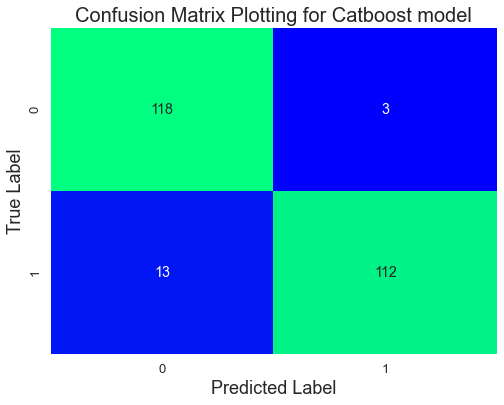

In [97]:
plt.figure(figsize=(8,6))
sns.set(font_scale=1.2)
sns.heatmap(cm_nn, annot=True, fmt = 'g', cmap="winter", cbar = False)
plt.xlabel("Predicted Label", size = 18)
plt.ylabel("True Label", size = 18)
plt.title("Confusion Matrix Plotting for Catboost model", size = 20)

In [38]:
test_pred = clf.predict_proba(scaled_df)[:, 1]
print('ROC score of Logistic Regression on the whole data', roc_auc_score(y, test_pred))

ROC score of Logistic Regression on the whole data 0.9913602855758437


## Tensorflow

In [20]:
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras.layers import Dropout
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense
from tensorflow.keras.layers import BatchNormalization
from sklearn import metrics
from sklearn.preprocessing import StandardScaler
from tensorflow.keras.callbacks import EarlyStopping
from sklearn import preprocessing
from sklearn.metrics import confusion_matrix

In [72]:
model = Sequential()
model.add(Dense(X_train.shape[1], activation = 'relu', input_dim = X_train.shape[1]))
model.add(BatchNormalization())

model.add(Dense(128, activation = 'relu'))
model.add(BatchNormalization())
model.add(Dropout(0.2))

model.add(Dense(512, activation = 'relu'))
model.add(BatchNormalization())
model.add(Dropout(0.5))

model.add(Dense(128, activation = 'relu'))
model.add(BatchNormalization())
model.add(Dropout(0.2))

model.add(Dense(64, activation = 'relu'))
model.add(BatchNormalization())
model.add(Dropout(0.5))

model.add(Dense(32, activation = 'relu'))
model.add(BatchNormalization())
model.add(Dropout(0.5))

model.add(Dense(1, activation = 'sigmoid'))

In [73]:
optimizer = keras.optimizers.Adam(lr=0.0001)
model.compile(optimizer = optimizer, loss = 'binary_crossentropy')

In [74]:
early_stop = EarlyStopping(monitor='val_loss', mode='min', verbose=1, patience = 10)

In [75]:
history = model.fit(x=X_train, y=y_train, batch_size = 100, epochs=200,
          validation_data=(X_test, y_test), verbose=1,
          callbacks=[early_stop])

Epoch 1/200
8/8 [==============================] - 3s 63ms/step - loss: 1.2619 - val_loss: 0.9044
Epoch 2/200
8/8 [==============================] - 0s 17ms/step - loss: 0.9975 - val_loss: 0.8082
Epoch 3/200
8/8 [==============================] - 0s 18ms/step - loss: 1.0015 - val_loss: 0.7525
Epoch 4/200
8/8 [==============================] - 0s 18ms/step - loss: 0.9543 - val_loss: 0.7195
Epoch 5/200
8/8 [==============================] - 0s 17ms/step - loss: 0.9066 - val_loss: 0.6977
Epoch 6/200
8/8 [==============================] - 0s 18ms/step - loss: 0.8101 - val_loss: 0.6826
Epoch 7/200
8/8 [==============================] - 0s 19ms/step - loss: 0.7288 - val_loss: 0.6705
Epoch 8/200
8/8 [==============================] - 0s 18ms/step - loss: 0.7821 - val_loss: 0.6572
Epoch 9/200
8/8 [==============================] - 0s 18ms/step - loss: 0.7560 - val_loss: 0.6428
Epoch 10/200
8/8 [==============================] - 0s 17ms/step - loss: 0.6443 - val_loss: 0.6260
Epoch 11/200
8/8 [=

Epoch 84/200
8/8 [==============================] - 0s 16ms/step - loss: 0.2795 - val_loss: 0.2111
Epoch 85/200
8/8 [==============================] - 0s 18ms/step - loss: 0.2518 - val_loss: 0.2114
Epoch 86/200
8/8 [==============================] - 0s 21ms/step - loss: 0.2570 - val_loss: 0.2121
Epoch 87/200
8/8 [==============================] - 0s 20ms/step - loss: 0.2279 - val_loss: 0.2117
Epoch 88/200
8/8 [==============================] - 0s 21ms/step - loss: 0.2491 - val_loss: 0.2119
Epoch 89/200
8/8 [==============================] - 0s 20ms/step - loss: 0.2766 - val_loss: 0.2124
Epoch 90/200
8/8 [==============================] - 0s 20ms/step - loss: 0.2868 - val_loss: 0.2130
Epoch 91/200
8/8 [==============================] - 0s 20ms/step - loss: 0.2360 - val_loss: 0.2130
Epoch 92/200
8/8 [==============================] - 0s 17ms/step - loss: 0.2448 - val_loss: 0.2125
Epoch 93/200
8/8 [==============================] - 0s 17ms/step - loss: 0.2330 - val_loss: 0.2124
Epoch 94/2

Text(0.5, 1.0, 'Loss for both Training and Validation')

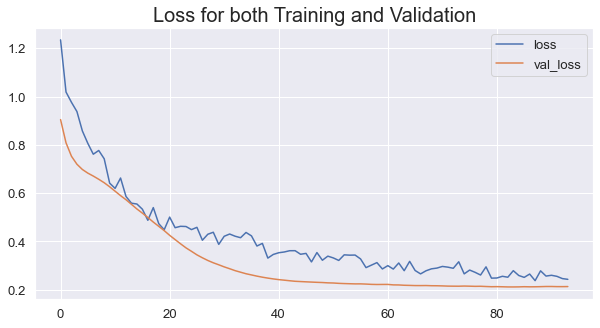

In [76]:
evaluation_metrics=pd.DataFrame(model.history.history)
evaluation_metrics.plot(figsize=(10,5))
plt.title("Loss for both Training and Validation", size = 20)

### ROC score on test data

In [89]:
test_pred = model.predict(X_test)
test_pred_labels = model.predict_classes(X_test)
print(roc_auc_score(y_test, test_pred))

0.9662809917355372


C:\Users\egadi\anaconda3\lib\site-packages\tensorflow\python\keras\engine\sequential.py:450: UserWarning: `model.predict_classes()` is deprecated and will be removed after 2021-01-01. Please use instead:* `np.argmax(model.predict(x), axis=-1)`,   if your model does multi-class classification   (e.g. if it uses a `softmax` last-layer activation).* `(model.predict(x) > 0.5).astype("int32")`,   if your model does binary classification   (e.g. if it uses a `sigmoid` last-layer activation).
  warnings.warn('`model.predict_classes()` is deprecated and '


### ROC score on all data

In [92]:
test_pred_all = model.predict(scaled_df)
test_pred_all_labels = model.predict_classes(scaled_df)
print(roc_auc_score(y, test_pred_all))

C:\Users\egadi\anaconda3\lib\site-packages\tensorflow\python\keras\engine\sequential.py:450: UserWarning: `model.predict_classes()` is deprecated and will be removed after 2021-01-01. Please use instead:* `np.argmax(model.predict(x), axis=-1)`,   if your model does multi-class classification   (e.g. if it uses a `softmax` last-layer activation).* `(model.predict(x) > 0.5).astype("int32")`,   if your model does binary classification   (e.g. if it uses a `sigmoid` last-layer activation).
  warnings.warn('`model.predict_classes()` is deprecated and '


0.9793698775933999


## Confusion matrix for test data

In [90]:
cm_nn=confusion_matrix(y_test, test_pred_labels)
cm_nn

array([[116,   5],
       [ 12, 113]], dtype=int64)

Text(0.5, 1.0, 'Confusion Matrix Plotting for Neural Network model')

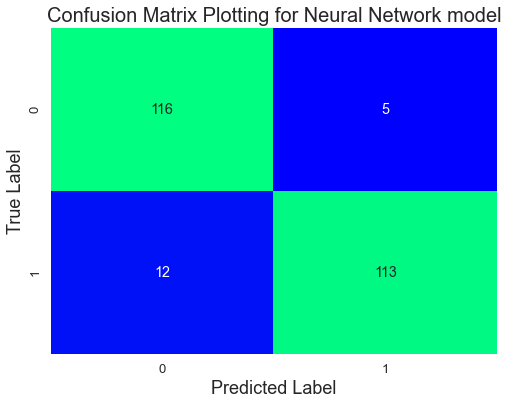

In [91]:
plt.figure(figsize=(8,6))
sns.set(font_scale=1.2)
sns.heatmap(cm_nn, annot=True, fmt = 'g', cmap="winter", cbar = False)
plt.xlabel("Predicted Label", size = 18)
plt.ylabel("True Label", size = 18)
plt.title("Confusion Matrix Plotting for Neural Network model", size = 20)

## Confusion Matrix for the all data

In [94]:
cm_nn=confusion_matrix(y, test_pred_all_labels)
cm_nn

array([[268208,  16107],
       [    36,    456]], dtype=int64)

Text(0.5, 1.0, 'Confusion Matrix Plotting for Neural Network model')

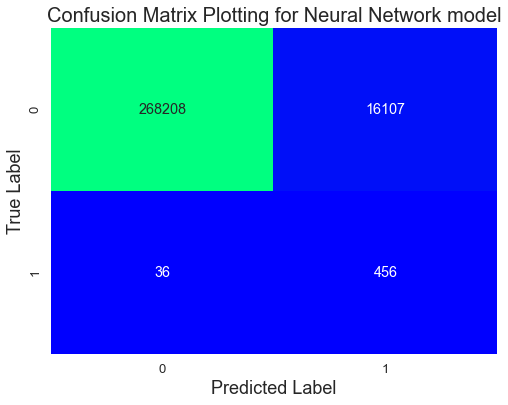

In [95]:
plt.figure(figsize=(8,6))
sns.set(font_scale=1.2)
sns.heatmap(cm_nn, annot=True, fmt = 'g', cmap="winter", cbar = False)
plt.xlabel("Predicted Label", size = 18)
plt.ylabel("True Label", size = 18)
plt.title("Confusion Matrix Plotting for Neural Network model", size = 20)

# Hyperparameter optimization with Optuna library 

In [120]:
import optuna
import sklearn.datasets
import sklearn.ensemble
import sklearn.model_selection
import sklearn.svm
import lightgbm as lgb
import catboost as cb

In [114]:
# FYI: Objective functions can take additional arguments
# (https://optuna.readthedocs.io/en/stable/faq.html#objective-func-additional-args).
def objective(trial):
#     iris = sklearn.datasets.load_iris()
#     x, y = iris.data, iris.target

    classifier_name = trial.suggest_categorical("classifier", ["SVC", "RandomForest"])
    if classifier_name == "SVC":
        svc_c = trial.suggest_float("svc_c", 1e-10, 1e10, log=True)
        classifier_obj = sklearn.svm.SVC(C=svc_c, gamma="auto")
    else:
        rf_max_depth = trial.suggest_int("rf_max_depth", 2, 32, log=True)
        classifier_obj = sklearn.ensemble.RandomForestClassifier(
            max_depth=rf_max_depth, n_estimators=10
        )

    score = sklearn.model_selection.cross_val_score(classifier_obj, X_under, y_under, n_jobs=-1, cv=3, scoring='roc_auc')
    accuracy = score.mean()
    return accuracy


In [115]:
study = optuna.create_study(direction="maximize")
study.optimize(objective, n_trials=100)
print(study.best_trial)

[I 2021-04-23 10:55:23,432] A new study created in memory with name: no-name-6216e590-8a33-4bbf-8f7f-ed1f29566523
[I 2021-04-23 10:55:23,551] Trial 0 finished with value: 0.956028157842554 and parameters: {'classifier': 'RandomForest', 'rf_max_depth': 5}. Best is trial 0 with value: 0.956028157842554.
[I 2021-04-23 10:55:23,669] Trial 1 finished with value: 0.9557059290105095 and parameters: {'classifier': 'RandomForest', 'rf_max_depth': 19}. Best is trial 0 with value: 0.956028157842554.
[I 2021-04-23 10:55:23,793] Trial 2 finished with value: 0.9528926234384295 and parameters: {'classifier': 'SVC', 'svc_c': 31.569817286180786}. Best is trial 0 with value: 0.956028157842554.
[I 2021-04-23 10:55:23,917] Trial 3 finished with value: 0.9609049672813802 and parameters: {'classifier': 'RandomForest', 'rf_max_depth': 7}. Best is trial 3 with value: 0.9609049672813802.
[I 2021-04-23 10:55:24,019] Trial 4 finished with value: 0.9603038865754511 and parameters: {'classifier': 'RandomForest', '

[I 2021-04-23 10:55:27,209] Trial 40 finished with value: 0.9661225956771763 and parameters: {'classifier': 'RandomForest', 'rf_max_depth': 4}. Best is trial 39 with value: 0.9684587547094984.
[I 2021-04-23 10:55:27,280] Trial 41 finished with value: 0.9565424846321634 and parameters: {'classifier': 'RandomForest', 'rf_max_depth': 4}. Best is trial 39 with value: 0.9684587547094984.
[I 2021-04-23 10:55:27,371] Trial 42 finished with value: 0.9515417410271664 and parameters: {'classifier': 'RandomForest', 'rf_max_depth': 2}. Best is trial 39 with value: 0.9684587547094984.
[I 2021-04-23 10:55:27,488] Trial 43 finished with value: 0.9574224172119769 and parameters: {'classifier': 'RandomForest', 'rf_max_depth': 5}. Best is trial 39 with value: 0.9684587547094984.
[I 2021-04-23 10:55:27,560] Trial 44 finished with value: 0.9525394110648424 and parameters: {'classifier': 'RandomForest', 'rf_max_depth': 3}. Best is trial 39 with value: 0.9684587547094984.
[I 2021-04-23 10:55:27,628] Trial 4

[I 2021-04-23 10:55:30,409] Trial 80 finished with value: 0.9370724271267102 and parameters: {'classifier': 'RandomForest', 'rf_max_depth': 2}. Best is trial 46 with value: 0.9695679654967281.
[I 2021-04-23 10:55:30,480] Trial 81 finished with value: 0.9697414733293673 and parameters: {'classifier': 'RandomForest', 'rf_max_depth': 3}. Best is trial 81 with value: 0.9697414733293673.
[I 2021-04-23 10:55:30,544] Trial 82 finished with value: 0.9577322526274044 and parameters: {'classifier': 'RandomForest', 'rf_max_depth': 3}. Best is trial 81 with value: 0.9697414733293673.
[I 2021-04-23 10:55:30,593] Trial 83 finished with value: 0.9488399762046401 and parameters: {'classifier': 'RandomForest', 'rf_max_depth': 2}. Best is trial 81 with value: 0.9697414733293673.
[I 2021-04-23 10:55:30,660] Trial 84 finished with value: 0.9655958754709499 and parameters: {'classifier': 'RandomForest', 'rf_max_depth': 2}. Best is trial 81 with value: 0.9697414733293673.
[I 2021-04-23 10:55:30,727] Trial 8

FrozenTrial(number=81, values=[0.9697414733293673], datetime_start=datetime.datetime(2021, 4, 23, 10, 55, 30, 410471), datetime_complete=datetime.datetime(2021, 4, 23, 10, 55, 30, 480150), params={'classifier': 'RandomForest', 'rf_max_depth': 3}, distributions={'classifier': CategoricalDistribution(choices=('SVC', 'RandomForest')), 'rf_max_depth': IntLogUniformDistribution(high=32, low=2, step=1)}, user_attrs={}, system_attrs={}, intermediate_values={}, trial_id=81, state=TrialState.COMPLETE, value=None)


In [140]:
import xgboost as xgb

def objective(trial):
    (data, target) = sklearn.datasets.load_breast_cancer(return_X_y=True)
    train_x, valid_x, train_y, valid_y = train_test_split(X_under, y_under, test_size=0.25)
    dtrain = xgb.DMatrix(train_x, label=train_y)
    dvalid = xgb.DMatrix(valid_x, label=valid_y)

    param = {
        "verbosity": 0,
        "objective": "binary:logistic",
        # use exact for small dataset.
        "tree_method": "exact",
        # defines booster, gblinear for linear functions.
        "booster": trial.suggest_categorical("booster", ["gbtree", "gblinear", "dart"]),
        # L2 regularization weight.
        "lambda": trial.suggest_float("lambda", 1e-8, 1.0, log=True),
        # L1 regularization weight.
        "alpha": trial.suggest_float("alpha", 1e-8, 1.0, log=True),
        # sampling ratio for training data.
        "subsample": trial.suggest_float("subsample", 0.2, 1.0),
        # sampling according to each tree.
        "colsample_bytree": trial.suggest_float("colsample_bytree", 0.2, 1.0),
    }

    if param["booster"] in ["gbtree", "dart"]:
        # maximum depth of the tree, signifies complexity of the tree.
        param["max_depth"] = trial.suggest_int("max_depth", 3, 9, step=2)
        # minimum child weight, larger the term more conservative the tree.
        param["min_child_weight"] = trial.suggest_int("min_child_weight", 2, 10)
        param["eta"] = trial.suggest_float("eta", 1e-8, 1.0, log=True)
        # defines how selective algorithm is.
        param["gamma"] = trial.suggest_float("gamma", 1e-8, 1.0, log=True)
        param["grow_policy"] = trial.suggest_categorical("grow_policy", ["depthwise", "lossguide"])

    if param["booster"] == "dart":
        param["sample_type"] = trial.suggest_categorical("sample_type", ["uniform", "weighted"])
        param["normalize_type"] = trial.suggest_categorical("normalize_type", ["tree", "forest"])
        param["rate_drop"] = trial.suggest_float("rate_drop", 1e-8, 1.0, log=True)
        param["skip_drop"] = trial.suggest_float("skip_drop", 1e-8, 1.0, log=True)

    bst = xgb.train(param, dtrain)
    preds = bst.predict(dvalid)
    pred_labels = np.rint(preds)
    accuracy = sklearn.metrics.roc_auc_score(valid_y, pred_labels)
    return accuracy

In [141]:
lgb_study = optuna.create_study(direction="maximize")
lgb_study.optimize(objective, n_trials=100, timeout=600)

print("Number of finished trials: ", len(study.trials))
print("Best trial:")
trial = lgb_study.best_trial

print("  Value: {}".format(trial.value))
print("  Params: ")
for key, value in trial.params.items():
    print("    {}: {}".format(key, value))

[I 2021-04-23 12:51:19,165] A new study created in memory with name: no-name-6e77cf8d-5a25-4140-9897-a3239dc743c9
[I 2021-04-23 12:51:19,226] Trial 0 finished with value: 0.9274193548387097 and parameters: {'booster': 'gbtree', 'lambda': 0.004232780397760567, 'alpha': 0.05625341322765816, 'subsample': 0.41070179668702933, 'colsample_bytree': 0.31291040444108065, 'max_depth': 3, 'min_child_weight': 9, 'eta': 0.009673621121734066, 'gamma': 8.48946051907885e-05, 'grow_policy': 'depthwise'}. Best is trial 0 with value: 0.9274193548387097.
[I 2021-04-23 12:51:19,299] Trial 1 finished with value: 0.9196859903381642 and parameters: {'booster': 'dart', 'lambda': 0.0003704179574451095, 'alpha': 0.0016409313455948201, 'subsample': 0.3037193355381385, 'colsample_bytree': 0.9071376645283278, 'max_depth': 5, 'min_child_weight': 9, 'eta': 0.000550293449712148, 'gamma': 0.7866042236287456, 'grow_policy': 'depthwise', 'sample_type': 'uniform', 'normalize_type': 'tree', 'rate_drop': 4.514447540906817e-

[I 2021-04-23 12:51:20,904] Trial 20 finished with value: 0.9262224574869318 and parameters: {'booster': 'gblinear', 'lambda': 4.982239607599668e-05, 'alpha': 2.904258552676597e-07, 'subsample': 0.7435650274462017, 'colsample_bytree': 0.7002379388885744}. Best is trial 14 with value: 0.9615231259968101.
[I 2021-04-23 12:51:20,997] Trial 21 finished with value: 0.9507936507936509 and parameters: {'booster': 'gblinear', 'lambda': 0.026486521776716496, 'alpha': 0.00027849212306549657, 'subsample': 0.5365034855797968, 'colsample_bytree': 0.5615658747864946}. Best is trial 14 with value: 0.9615231259968101.
[I 2021-04-23 12:51:21,077] Trial 22 finished with value: 0.9587301587301588 and parameters: {'booster': 'gblinear', 'lambda': 0.00877938146126747, 'alpha': 0.00019498575127666642, 'subsample': 0.5199959917888061, 'colsample_bytree': 0.5428373239340997}. Best is trial 14 with value: 0.9615231259968101.
[I 2021-04-23 12:51:21,173] Trial 23 finished with value: 0.9492042440318303 and param

[I 2021-04-23 12:51:23,401] Trial 44 finished with value: 0.934126984126984 and parameters: {'booster': 'gblinear', 'lambda': 0.017561200547739693, 'alpha': 8.815049310874722e-05, 'subsample': 0.47237672043878987, 'colsample_bytree': 0.41634962695891287}. Best is trial 14 with value: 0.9615231259968101.
[I 2021-04-23 12:51:23,544] Trial 45 finished with value: 0.928032309322034 and parameters: {'booster': 'gbtree', 'lambda': 0.3040825136394797, 'alpha': 0.0022361868865228163, 'subsample': 0.5259985551792206, 'colsample_bytree': 0.5006677132662593, 'max_depth': 3, 'min_child_weight': 5, 'eta': 0.4127339656888837, 'gamma': 0.011833389486211628, 'grow_policy': 'lossguide'}. Best is trial 14 with value: 0.9615231259968101.
[I 2021-04-23 12:51:23,643] Trial 46 finished with value: 0.936111111111111 and parameters: {'booster': 'gblinear', 'lambda': 0.054435235279657816, 'alpha': 0.0010079351322524034, 'subsample': 0.37847650815577316, 'colsample_bytree': 0.27656967494368756}. Best is trial 1

[I 2021-04-23 12:51:26,109] Trial 68 finished with value: 0.9281746031746032 and parameters: {'booster': 'gblinear', 'lambda': 0.0177070385177365, 'alpha': 0.00018613342283065883, 'subsample': 0.4026101899419554, 'colsample_bytree': 0.5787780451674249}. Best is trial 62 with value: 0.9703389830508475.
[I 2021-04-23 12:51:26,197] Trial 69 finished with value: 0.9466776859504132 and parameters: {'booster': 'gblinear', 'lambda': 0.008387262643902828, 'alpha': 1.2921437711595712e-07, 'subsample': 0.5236918027138493, 'colsample_bytree': 0.7642688935997832}. Best is trial 62 with value: 0.9703389830508475.
[I 2021-04-23 12:51:26,289] Trial 70 finished with value: 0.9422619047619046 and parameters: {'booster': 'gblinear', 'lambda': 0.0016819840470642315, 'alpha': 0.0029330494176785155, 'subsample': 0.6170841587495469, 'colsample_bytree': 0.6954442678318513}. Best is trial 62 with value: 0.9703389830508475.
[I 2021-04-23 12:51:26,393] Trial 71 finished with value: 0.946031746031746 and paramet

[I 2021-04-23 12:51:28,667] Trial 93 finished with value: 0.9385188635305076 and parameters: {'booster': 'gblinear', 'lambda': 0.19763833806247974, 'alpha': 7.025872723156978e-05, 'subsample': 0.4861570081449068, 'colsample_bytree': 0.5126082826383682}. Best is trial 62 with value: 0.9703389830508475.
[I 2021-04-23 12:51:28,762] Trial 94 finished with value: 0.9279761904761904 and parameters: {'booster': 'gblinear', 'lambda': 0.004981615967715825, 'alpha': 0.0017057386700246068, 'subsample': 0.6096899271089424, 'colsample_bytree': 0.7244678556730636}. Best is trial 62 with value: 0.9703389830508475.
[I 2021-04-23 12:51:28,868] Trial 95 finished with value: 0.9059409226684367 and parameters: {'booster': 'gblinear', 'lambda': 0.11248179701957961, 'alpha': 0.00016767178985825426, 'subsample': 0.528630574020562, 'colsample_bytree': 0.2743644321753475}. Best is trial 62 with value: 0.9703389830508475.
[I 2021-04-23 12:51:28,978] Trial 96 finished with value: 0.9628575211864407 and parameter

Number of finished trials:  100
Best trial:
  Value: 0.9703389830508475
  Params: 
    booster: gblinear
    lambda: 0.020632276413994743
    alpha: 0.0013057102417475502
    subsample: 0.49450288106225965
    colsample_bytree: 0.5604334985970185


### Still Light Boost Classifier with hyperparamet optimization in optuna performs better than XGBoost

## Now use Cat Boost

In [162]:
def objective(trial):
#     data, target = load_breast_cancer(return_X_y=True)
    train_x, valid_x, train_y, valid_y = train_test_split(X_under, y_under, test_size=0.3)

    param = {
        "objective": trial.suggest_categorical("objective", ["Logloss", "CrossEntropy"]),
        "colsample_bylevel": trial.suggest_float("colsample_bylevel", 0.01, 0.1),
        "depth": trial.suggest_int("depth", 1, 12),
        "boosting_type": trial.suggest_categorical("boosting_type", ["Ordered", "Plain"]),
        "bootstrap_type": trial.suggest_categorical(
            "bootstrap_type", ["Bayesian", "Bernoulli", "MVS"]
        ),
        "used_ram_limit": "3gb",
    }

    if param["bootstrap_type"] == "Bayesian":
        param["bagging_temperature"] = trial.suggest_float("bagging_temperature", 0, 10)
    elif param["bootstrap_type"] == "Bernoulli":
        param["subsample"] = trial.suggest_float("subsample", 0.1, 1)

    gbm = cb.CatBoostClassifier(**param)

    gbm.fit(train_x, train_y, eval_set=[(valid_x, valid_y)], verbose=0, early_stopping_rounds=100)

    preds = gbm.predict(valid_x)
    pred_labels = np.rint(preds)
    accuracy = sklearn.metrics.roc_auc_score(valid_y, pred_labels)
    return accuracy


In [163]:
cat_study = optuna.create_study(direction="maximize")
cat_study.optimize(objective, n_trials=100, timeout=600)

print("Number of finished trials: {}".format(len(study.trials)))

print("Best trial:")
trial = cat_study.best_trial

print("  Value: {}".format(trial.value))

print("  Params: ")
for key, value in trial.params.items():
    print("    {}: {}".format(key, value))

[I 2021-04-23 18:44:36,577] A new study created in memory with name: no-name-e80ad019-6aa2-4bac-8899-0ed23f702051
[I 2021-04-23 18:44:37,615] Trial 0 finished with value: 0.9382332643202208 and parameters: {'objective': 'Logloss', 'colsample_bylevel': 0.06152703003847892, 'depth': 5, 'boosting_type': 'Plain', 'bootstrap_type': 'MVS'}. Best is trial 0 with value: 0.9382332643202208.
[I 2021-04-23 18:44:38,800] Trial 1 finished with value: 0.9329939460649421 and parameters: {'objective': 'Logloss', 'colsample_bylevel': 0.03840639033352498, 'depth': 3, 'boosting_type': 'Plain', 'bootstrap_type': 'MVS'}. Best is trial 0 with value: 0.9382332643202208.
[I 2021-04-23 18:44:39,678] Trial 2 finished with value: 0.9518168904366953 and parameters: {'objective': 'CrossEntropy', 'colsample_bylevel': 0.012231678647759866, 'depth': 12, 'boosting_type': 'Plain', 'bootstrap_type': 'Bayesian', 'bagging_temperature': 5.367910518460976}. Best is trial 2 with value: 0.9518168904366953.
[I 2021-04-23 18:44

[I 2021-04-23 18:45:55,881] Trial 26 finished with value: 0.9197260273972603 and parameters: {'objective': 'CrossEntropy', 'colsample_bylevel': 0.05843640409521539, 'depth': 11, 'boosting_type': 'Plain', 'bootstrap_type': 'Bayesian', 'bagging_temperature': 6.626167173741066}. Best is trial 3 with value: 0.9560810810810809.
[I 2021-04-23 18:46:00,435] Trial 27 finished with value: 0.9453196978072599 and parameters: {'objective': 'Logloss', 'colsample_bylevel': 0.0459663781885336, 'depth': 6, 'boosting_type': 'Ordered', 'bootstrap_type': 'Bayesian', 'bagging_temperature': 4.737815472131759}. Best is trial 3 with value: 0.9560810810810809.
[I 2021-04-23 18:46:01,889] Trial 28 finished with value: 0.9386301369863014 and parameters: {'objective': 'CrossEntropy', 'colsample_bylevel': 0.033379467869595475, 'depth': 9, 'boosting_type': 'Plain', 'bootstrap_type': 'Bayesian', 'bagging_temperature': 2.114939522402265}. Best is trial 3 with value: 0.9560810810810809.
[I 2021-04-23 18:46:02,642] Tr

[I 2021-04-23 18:46:45,469] Trial 51 finished with value: 0.9489041095890411 and parameters: {'objective': 'Logloss', 'colsample_bylevel': 0.060961702006069825, 'depth': 3, 'boosting_type': 'Plain', 'bootstrap_type': 'Bernoulli', 'subsample': 0.6637004917608671}. Best is trial 3 with value: 0.9560810810810809.
[I 2021-04-23 18:46:46,091] Trial 52 finished with value: 0.9182005023978077 and parameters: {'objective': 'Logloss', 'colsample_bylevel': 0.05971151340390552, 'depth': 2, 'boosting_type': 'Plain', 'bootstrap_type': 'Bernoulli', 'subsample': 0.6753101551396378}. Best is trial 3 with value: 0.9560810810810809.
[I 2021-04-23 18:46:47,384] Trial 53 finished with value: 0.9422374429223745 and parameters: {'objective': 'Logloss', 'colsample_bylevel': 0.06347131727230469, 'depth': 3, 'boosting_type': 'Plain', 'bootstrap_type': 'Bernoulli', 'subsample': 0.610504763970406}. Best is trial 3 with value: 0.9560810810810809.
[I 2021-04-23 18:46:48,302] Trial 54 finished with value: 0.9475446

[I 2021-04-23 18:47:15,913] Trial 77 finished with value: 0.9342026996110729 and parameters: {'objective': 'Logloss', 'colsample_bylevel': 0.04839345671200195, 'depth': 6, 'boosting_type': 'Plain', 'bootstrap_type': 'MVS'}. Best is trial 71 with value: 0.9570540935672515.
[I 2021-04-23 18:47:17,267] Trial 78 finished with value: 0.9274282055972197 and parameters: {'objective': 'Logloss', 'colsample_bylevel': 0.05913829762704778, 'depth': 7, 'boosting_type': 'Plain', 'bootstrap_type': 'MVS'}. Best is trial 71 with value: 0.9570540935672515.
[I 2021-04-23 18:47:18,097] Trial 79 finished with value: 0.9316174788377946 and parameters: {'objective': 'Logloss', 'colsample_bylevel': 0.04317458641482655, 'depth': 6, 'boosting_type': 'Plain', 'bootstrap_type': 'MVS'}. Best is trial 71 with value: 0.9570540935672515.
[I 2021-04-23 18:47:19,721] Trial 80 finished with value: 0.9256756756756757 and parameters: {'objective': 'Logloss', 'colsample_bylevel': 0.06578630970255944, 'depth': 9, 'boosting

Number of finished trials: 100
Best trial:
  Value: 0.9649038240830006
  Params: 
    objective: Logloss
    colsample_bylevel: 0.03696053995484115
    depth: 9
    boosting_type: Plain
    bootstrap_type: Bayesian
    bagging_temperature: 7.185463030768075


In [149]:
def objective(trial):
#     data, target = sklearn.datasets.load_breast_cancer(return_X_y=True)
    train_x, valid_x, train_y, valid_y = train_test_split(X_under, y_under, test_size=0.25)
    dtrain = lgb.Dataset(train_x, label=train_y)

    param = {
        "objective": "binary",
        "metric": "binary_logloss",
        "verbosity": -1,
        "boosting_type": "gbdt",
        "lambda_l1": trial.suggest_float("lambda_l1", 1e-8, 10.0, log=True),
        "lambda_l2": trial.suggest_float("lambda_l2", 1e-8, 10.0, log=True),
        "num_leaves": trial.suggest_int("num_leaves", 2, 256),
        "feature_fraction": trial.suggest_float("feature_fraction", 0.4, 1.0),
        "bagging_fraction": trial.suggest_float("bagging_fraction", 0.4, 1.0),
        "bagging_freq": trial.suggest_int("bagging_freq", 1, 7),
        "min_child_samples": trial.suggest_int("min_child_samples", 5, 100),
    }

    gbm = lgb.train(param, dtrain)
    preds = gbm.predict(valid_x)
    pred_labels = np.rint(preds)
    accuracy = sklearn.metrics.roc_auc_score(valid_y, pred_labels)
    return accuracy

In [150]:
lgb_study = optuna.create_study(direction="maximize")
lgb_study.optimize(objective, n_trials=100, timeout=600)

print("Number of finished trials: ", len(study.trials))
print("Best trial:")
trial = lgb_study.best_trial

print("  Value: {}".format(trial.value))
print("  Params: ")
for key, value in trial.params.items():
    print("    {}: {}".format(key, value))

[I 2021-04-23 18:36:31,926] A new study created in memory with name: no-name-7f7b3292-4ff1-401f-a419-805e1cc8c69d
[I 2021-04-23 18:36:32,189] Trial 0 finished with value: 0.9210317460317461 and parameters: {'lambda_l1': 0.0011191876091297302, 'lambda_l2': 9.510583161871728e-06, 'num_leaves': 148, 'feature_fraction': 0.9701463277598474, 'bagging_fraction': 0.8271426980249204, 'bagging_freq': 4, 'min_child_samples': 14}. Best is trial 0 with value: 0.9210317460317461.
[I 2021-04-23 18:36:32,290] Trial 1 finished with value: 0.9352194606028557 and parameters: {'lambda_l1': 0.00029017341551123123, 'lambda_l2': 2.342856863653051, 'num_leaves': 168, 'feature_fraction': 0.8216697474631169, 'bagging_fraction': 0.6554977018960042, 'bagging_freq': 4, 'min_child_samples': 67}. Best is trial 1 with value: 0.9352194606028557.
[I 2021-04-23 18:36:32,395] Trial 2 finished with value: 0.9232548915917503 and parameters: {'lambda_l1': 0.004078384124754675, 'lambda_l2': 1.7742908720143946, 'num_leaves': 

[I 2021-04-23 18:36:35,257] Trial 22 finished with value: 0.9343611460332164 and parameters: {'lambda_l1': 9.072678965494989, 'lambda_l2': 3.82779154949429e-08, 'num_leaves': 254, 'feature_fraction': 0.7456451905009577, 'bagging_fraction': 0.8517871161209857, 'bagging_freq': 3, 'min_child_samples': 64}. Best is trial 5 with value: 0.9659814323607429.
[I 2021-04-23 18:36:35,397] Trial 23 finished with value: 0.9422170594092267 and parameters: {'lambda_l1': 0.9895613872689065, 'lambda_l2': 3.479061053565881e-05, 'num_leaves': 227, 'feature_fraction': 0.9604403736032004, 'bagging_fraction': 0.9220510689639295, 'bagging_freq': 3, 'min_child_samples': 76}. Best is trial 5 with value: 0.9659814323607429.
[I 2021-04-23 18:36:35,529] Trial 24 finished with value: 0.9631147540983607 and parameters: {'lambda_l1': 0.09660535096176218, 'lambda_l2': 5.951445310659257e-07, 'num_leaves': 173, 'feature_fraction': 0.8663370027275232, 'bagging_fraction': 0.7838407386211186, 'bagging_freq': 2, 'min_child

[I 2021-04-23 18:36:38,588] Trial 45 finished with value: 0.9417855957517425 and parameters: {'lambda_l1': 0.0022107751658376382, 'lambda_l2': 0.07516953117015249, 'num_leaves': 88, 'feature_fraction': 0.8474090866709543, 'bagging_fraction': 0.8869222389189447, 'bagging_freq': 4, 'min_child_samples': 96}. Best is trial 5 with value: 0.9659814323607429.
[I 2021-04-23 18:36:38,725] Trial 46 finished with value: 0.9384132231404958 and parameters: {'lambda_l1': 5.72853543450052e-07, 'lambda_l2': 1.0059922233102157e-08, 'num_leaves': 194, 'feature_fraction': 0.7142656549687586, 'bagging_fraction': 0.7630902187885779, 'bagging_freq': 1, 'min_child_samples': 80}. Best is trial 5 with value: 0.9659814323607429.
[I 2021-04-23 18:36:38,866] Trial 47 finished with value: 0.9289405684754521 and parameters: {'lambda_l1': 0.048025071197148946, 'lambda_l2': 3.239574786743012e-08, 'num_leaves': 139, 'feature_fraction': 0.9169543296769878, 'bagging_fraction': 0.9351822693779305, 'bagging_freq': 2, 'min

[I 2021-04-23 18:36:42,175] Trial 68 finished with value: 0.942063492063492 and parameters: {'lambda_l1': 5.09006544300906, 'lambda_l2': 4.835322387019907, 'num_leaves': 223, 'feature_fraction': 0.8881304797172057, 'bagging_fraction': 0.8973927146530597, 'bagging_freq': 5, 'min_child_samples': 87}. Best is trial 62 with value: 0.9666070363744782.
[I 2021-04-23 18:36:42,325] Trial 69 finished with value: 0.9294374875770225 and parameters: {'lambda_l1': 0.059243543279485375, 'lambda_l2': 4.3929618189132755e-06, 'num_leaves': 209, 'feature_fraction': 0.9678218873682218, 'bagging_fraction': 0.7469111267142832, 'bagging_freq': 6, 'min_child_samples': 66}. Best is trial 62 with value: 0.9666070363744782.
[I 2021-04-23 18:36:42,480] Trial 70 finished with value: 0.9101458885941646 and parameters: {'lambda_l1': 0.008725626251209888, 'lambda_l2': 9.15324430875579e-06, 'num_leaves': 177, 'feature_fraction': 0.8022461402606518, 'bagging_fraction': 0.9126601264713404, 'bagging_freq': 5, 'min_child

[I 2021-04-23 18:36:45,830] Trial 91 finished with value: 0.9340964732349633 and parameters: {'lambda_l1': 0.06464997583825235, 'lambda_l2': 1.31944859595772e-08, 'num_leaves': 173, 'feature_fraction': 0.8852208415066432, 'bagging_fraction': 0.8789800819342181, 'bagging_freq': 7, 'min_child_samples': 86}. Best is trial 62 with value: 0.9666070363744782.
[I 2021-04-23 18:36:46,007] Trial 92 finished with value: 0.9404761904761905 and parameters: {'lambda_l1': 0.12266471949218825, 'lambda_l2': 1.0485375366612062e-08, 'num_leaves': 256, 'feature_fraction': 0.8945607158322533, 'bagging_fraction': 0.8594141182378993, 'bagging_freq': 6, 'min_child_samples': 82}. Best is trial 62 with value: 0.9666070363744782.
[I 2021-04-23 18:36:46,165] Trial 93 finished with value: 0.9392066115702479 and parameters: {'lambda_l1': 1.535728772445399, 'lambda_l2': 1.7690157741579955e-08, 'num_leaves': 179, 'feature_fraction': 0.8390185489962968, 'bagging_fraction': 0.8433301570704866, 'bagging_freq': 5, 'min_

Number of finished trials:  100
Best trial:
  Value: 0.9666070363744782
  Params: 
    lambda_l1: 0.07328306951354067
    lambda_l2: 1.0874414924431504e-08
    num_leaves: 159
    feature_fraction: 0.9403750719942507
    bagging_fraction: 0.833565638233047
    bagging_freq: 1
    min_child_samples: 78


In [164]:
?CatBoostClassifier

In [152]:
from sklearn.model_selection import StratifiedKFold

In [161]:
sss = StratifiedKFold()
roc = []
for train_idx, test_idx in sss.split(X_under, y_under):
    X_train, X_test = X_under.iloc[train_idx], X_under.iloc[test_idx]
    y_train, y_test = y_under.iloc[train_idx], y_under.iloc[test_idx]
    
    model = LGBMClassifier(num_leaves=159, min_child_samples=78)
    model.fit(X_train, y_train)
    y_predicted=model.predict_proba(X_test)
    roc.append(roc_auc_score(y_test, y_predicted[:, 1]))
    
print(np.mean(roc))

0.9712739641311071


In [157]:
sss = StratifiedKFold()
roc = []
for train_idx, test_idx in sss.split(X_under, y_under):
    X_train, X_test = X_under.iloc[train_idx], X_under.iloc[test_idx]
    y_train, y_test = y_under.iloc[train_idx], y_under.iloc[test_idx]
    
    model = CatBoostClassifier()
    model.fit(X_train, y_train)
    y_predicted=model.predict_proba(X_test)
    roc.append(roc_auc_score(y_test, y_predicted[:, 1]))
    
print(np.mean(roc))

Learning rate set to 0.009301
0:	learn: 0.6810538	total: 11.6ms	remaining: 11.5s
1:	learn: 0.6691565	total: 20.5ms	remaining: 10.3s
2:	learn: 0.6577122	total: 30.2ms	remaining: 10s
3:	learn: 0.6471634	total: 40.6ms	remaining: 10.1s
4:	learn: 0.6356949	total: 50.7ms	remaining: 10.1s
5:	learn: 0.6264519	total: 60.3ms	remaining: 10s
6:	learn: 0.6151336	total: 69.7ms	remaining: 9.89s
7:	learn: 0.6031934	total: 79.2ms	remaining: 9.82s
8:	learn: 0.5950997	total: 90.7ms	remaining: 9.99s
9:	learn: 0.5836878	total: 102ms	remaining: 10.1s
10:	learn: 0.5723878	total: 112ms	remaining: 10s
11:	learn: 0.5640140	total: 121ms	remaining: 9.93s
12:	learn: 0.5549778	total: 131ms	remaining: 9.91s
13:	learn: 0.5456292	total: 140ms	remaining: 9.87s
14:	learn: 0.5367435	total: 151ms	remaining: 9.89s
15:	learn: 0.5277788	total: 160ms	remaining: 9.85s
16:	learn: 0.5186076	total: 172ms	remaining: 9.94s
17:	learn: 0.5104504	total: 183ms	remaining: 9.97s
18:	learn: 0.5023051	total: 199ms	remaining: 10.3s
19:	lear

164:	learn: 0.1537846	total: 1.61s	remaining: 8.16s
165:	learn: 0.1531021	total: 1.62s	remaining: 8.15s
166:	learn: 0.1526170	total: 1.63s	remaining: 8.15s
167:	learn: 0.1519476	total: 1.65s	remaining: 8.15s
168:	learn: 0.1514839	total: 1.65s	remaining: 8.13s
169:	learn: 0.1509021	total: 1.66s	remaining: 8.12s
170:	learn: 0.1504051	total: 1.67s	remaining: 8.1s
171:	learn: 0.1499787	total: 1.68s	remaining: 8.08s
172:	learn: 0.1491603	total: 1.69s	remaining: 8.06s
173:	learn: 0.1486329	total: 1.69s	remaining: 8.04s
174:	learn: 0.1479646	total: 1.7s	remaining: 8.03s
175:	learn: 0.1475532	total: 1.71s	remaining: 8.01s
176:	learn: 0.1469793	total: 1.72s	remaining: 7.99s
177:	learn: 0.1463590	total: 1.73s	remaining: 7.97s
178:	learn: 0.1455129	total: 1.73s	remaining: 7.95s
179:	learn: 0.1449171	total: 1.74s	remaining: 7.94s
180:	learn: 0.1445023	total: 1.75s	remaining: 7.92s
181:	learn: 0.1441136	total: 1.76s	remaining: 7.9s
182:	learn: 0.1435335	total: 1.77s	remaining: 7.89s
183:	learn: 0.1

327:	learn: 0.0900141	total: 3.04s	remaining: 6.22s
328:	learn: 0.0898703	total: 3.05s	remaining: 6.21s
329:	learn: 0.0897005	total: 3.06s	remaining: 6.21s
330:	learn: 0.0895310	total: 3.07s	remaining: 6.2s
331:	learn: 0.0893258	total: 3.08s	remaining: 6.19s
332:	learn: 0.0890831	total: 3.08s	remaining: 6.18s
333:	learn: 0.0889133	total: 3.09s	remaining: 6.17s
334:	learn: 0.0887164	total: 3.1s	remaining: 6.16s
335:	learn: 0.0884732	total: 3.11s	remaining: 6.14s
336:	learn: 0.0882017	total: 3.12s	remaining: 6.13s
337:	learn: 0.0879681	total: 3.12s	remaining: 6.12s
338:	learn: 0.0876990	total: 3.13s	remaining: 6.11s
339:	learn: 0.0875276	total: 3.14s	remaining: 6.09s
340:	learn: 0.0873619	total: 3.15s	remaining: 6.08s
341:	learn: 0.0871542	total: 3.15s	remaining: 6.07s
342:	learn: 0.0869558	total: 3.16s	remaining: 6.06s
343:	learn: 0.0866657	total: 3.17s	remaining: 6.05s
344:	learn: 0.0864983	total: 3.18s	remaining: 6.04s
345:	learn: 0.0862954	total: 3.19s	remaining: 6.02s
346:	learn: 0.

496:	learn: 0.0614471	total: 4.64s	remaining: 4.7s
497:	learn: 0.0613261	total: 4.65s	remaining: 4.69s
498:	learn: 0.0611361	total: 4.66s	remaining: 4.68s
499:	learn: 0.0610127	total: 4.67s	remaining: 4.67s
500:	learn: 0.0608248	total: 4.68s	remaining: 4.66s
501:	learn: 0.0607033	total: 4.69s	remaining: 4.65s
502:	learn: 0.0605823	total: 4.7s	remaining: 4.64s
503:	learn: 0.0603758	total: 4.7s	remaining: 4.63s
504:	learn: 0.0602603	total: 4.71s	remaining: 4.62s
505:	learn: 0.0601172	total: 4.72s	remaining: 4.61s
506:	learn: 0.0599352	total: 4.73s	remaining: 4.6s
507:	learn: 0.0598298	total: 4.74s	remaining: 4.59s
508:	learn: 0.0596945	total: 4.75s	remaining: 4.58s
509:	learn: 0.0595420	total: 4.76s	remaining: 4.57s
510:	learn: 0.0594243	total: 4.76s	remaining: 4.56s
511:	learn: 0.0592571	total: 4.77s	remaining: 4.55s
512:	learn: 0.0590878	total: 4.78s	remaining: 4.54s
513:	learn: 0.0589507	total: 4.79s	remaining: 4.53s
514:	learn: 0.0587460	total: 4.79s	remaining: 4.52s
515:	learn: 0.05

663:	learn: 0.0431806	total: 6.07s	remaining: 3.07s
664:	learn: 0.0431433	total: 6.08s	remaining: 3.06s
665:	learn: 0.0430518	total: 6.09s	remaining: 3.06s
666:	learn: 0.0429513	total: 6.1s	remaining: 3.05s
667:	learn: 0.0428856	total: 6.11s	remaining: 3.04s
668:	learn: 0.0428225	total: 6.12s	remaining: 3.03s
669:	learn: 0.0427798	total: 6.13s	remaining: 3.02s
670:	learn: 0.0426699	total: 6.14s	remaining: 3.01s
671:	learn: 0.0425941	total: 6.14s	remaining: 3s
672:	learn: 0.0425108	total: 6.15s	remaining: 2.99s
673:	learn: 0.0424165	total: 6.16s	remaining: 2.98s
674:	learn: 0.0423541	total: 6.17s	remaining: 2.97s
675:	learn: 0.0422790	total: 6.18s	remaining: 2.96s
676:	learn: 0.0421751	total: 6.18s	remaining: 2.95s
677:	learn: 0.0420952	total: 6.19s	remaining: 2.94s
678:	learn: 0.0420118	total: 6.2s	remaining: 2.93s
679:	learn: 0.0420011	total: 6.21s	remaining: 2.92s
680:	learn: 0.0419241	total: 6.21s	remaining: 2.91s
681:	learn: 0.0418108	total: 6.22s	remaining: 2.9s
682:	learn: 0.0417

822:	learn: 0.0323142	total: 7.88s	remaining: 1.69s
823:	learn: 0.0322616	total: 7.89s	remaining: 1.69s
824:	learn: 0.0321583	total: 7.91s	remaining: 1.68s
825:	learn: 0.0321017	total: 7.92s	remaining: 1.67s
826:	learn: 0.0320670	total: 7.93s	remaining: 1.66s
827:	learn: 0.0320389	total: 7.95s	remaining: 1.65s
828:	learn: 0.0319603	total: 7.96s	remaining: 1.64s
829:	learn: 0.0318962	total: 7.97s	remaining: 1.63s
830:	learn: 0.0318015	total: 7.98s	remaining: 1.62s
831:	learn: 0.0316630	total: 7.99s	remaining: 1.61s
832:	learn: 0.0316099	total: 8.01s	remaining: 1.6s
833:	learn: 0.0315888	total: 8.02s	remaining: 1.6s
834:	learn: 0.0315099	total: 8.03s	remaining: 1.59s
835:	learn: 0.0314282	total: 8.04s	remaining: 1.58s
836:	learn: 0.0313842	total: 8.06s	remaining: 1.57s
837:	learn: 0.0313327	total: 8.07s	remaining: 1.56s
838:	learn: 0.0312712	total: 8.09s	remaining: 1.55s
839:	learn: 0.0311677	total: 8.1s	remaining: 1.54s
840:	learn: 0.0310908	total: 8.11s	remaining: 1.53s
841:	learn: 0.0

984:	learn: 0.0246539	total: 9.84s	remaining: 150ms
985:	learn: 0.0245976	total: 9.85s	remaining: 140ms
986:	learn: 0.0245733	total: 9.86s	remaining: 130ms
987:	learn: 0.0245300	total: 9.88s	remaining: 120ms
988:	learn: 0.0244952	total: 9.89s	remaining: 110ms
989:	learn: 0.0244499	total: 9.9s	remaining: 100ms
990:	learn: 0.0244146	total: 9.91s	remaining: 90ms
991:	learn: 0.0243845	total: 9.92s	remaining: 80ms
992:	learn: 0.0243286	total: 9.93s	remaining: 70ms
993:	learn: 0.0242592	total: 9.94s	remaining: 60ms
994:	learn: 0.0242182	total: 9.95s	remaining: 50ms
995:	learn: 0.0241848	total: 9.96s	remaining: 40ms
996:	learn: 0.0241487	total: 9.97s	remaining: 30ms
997:	learn: 0.0241115	total: 9.98s	remaining: 20ms
998:	learn: 0.0240781	total: 10s	remaining: 10ms
999:	learn: 0.0240135	total: 10s	remaining: 0us
Learning rate set to 0.009301
0:	learn: 0.6805201	total: 9.79ms	remaining: 9.78s
1:	learn: 0.6671276	total: 17.8ms	remaining: 8.86s
2:	learn: 0.6539073	total: 26.3ms	remaining: 8.76s
3

152:	learn: 0.1409716	total: 1.75s	remaining: 9.68s
153:	learn: 0.1403137	total: 1.77s	remaining: 9.7s
154:	learn: 0.1394016	total: 1.79s	remaining: 9.76s
155:	learn: 0.1387843	total: 1.81s	remaining: 9.77s
156:	learn: 0.1381531	total: 1.83s	remaining: 9.84s
157:	learn: 0.1375340	total: 1.85s	remaining: 9.86s
158:	learn: 0.1368655	total: 1.87s	remaining: 9.89s
159:	learn: 0.1359652	total: 1.89s	remaining: 9.91s
160:	learn: 0.1352609	total: 1.91s	remaining: 9.95s
161:	learn: 0.1346408	total: 1.93s	remaining: 9.97s
162:	learn: 0.1339769	total: 1.95s	remaining: 10s
163:	learn: 0.1335602	total: 1.97s	remaining: 10s
164:	learn: 0.1328633	total: 1.98s	remaining: 10s
165:	learn: 0.1322765	total: 2s	remaining: 10s
166:	learn: 0.1318162	total: 2.01s	remaining: 10s
167:	learn: 0.1310945	total: 2.03s	remaining: 10.1s
168:	learn: 0.1304727	total: 2.04s	remaining: 10.1s
169:	learn: 0.1299534	total: 2.06s	remaining: 10s
170:	learn: 0.1294101	total: 2.07s	remaining: 10s
171:	learn: 0.1289008	total: 2

317:	learn: 0.0767830	total: 3.52s	remaining: 7.56s
318:	learn: 0.0765491	total: 3.53s	remaining: 7.54s
319:	learn: 0.0761758	total: 3.54s	remaining: 7.53s
320:	learn: 0.0759359	total: 3.55s	remaining: 7.52s
321:	learn: 0.0757913	total: 3.56s	remaining: 7.5s
322:	learn: 0.0754911	total: 3.57s	remaining: 7.48s
323:	learn: 0.0752058	total: 3.58s	remaining: 7.47s
324:	learn: 0.0749291	total: 3.59s	remaining: 7.45s
325:	learn: 0.0747273	total: 3.59s	remaining: 7.43s
326:	learn: 0.0743627	total: 3.6s	remaining: 7.41s
327:	learn: 0.0741731	total: 3.61s	remaining: 7.4s
328:	learn: 0.0739326	total: 3.62s	remaining: 7.38s
329:	learn: 0.0738453	total: 3.63s	remaining: 7.36s
330:	learn: 0.0736191	total: 3.63s	remaining: 7.34s
331:	learn: 0.0733205	total: 3.64s	remaining: 7.33s
332:	learn: 0.0731390	total: 3.65s	remaining: 7.31s
333:	learn: 0.0728862	total: 3.66s	remaining: 7.29s
334:	learn: 0.0726489	total: 3.67s	remaining: 7.28s
335:	learn: 0.0724053	total: 3.67s	remaining: 7.26s
336:	learn: 0.0

478:	learn: 0.0500937	total: 4.96s	remaining: 5.4s
479:	learn: 0.0500007	total: 4.97s	remaining: 5.39s
480:	learn: 0.0499701	total: 4.98s	remaining: 5.38s
481:	learn: 0.0498759	total: 4.99s	remaining: 5.37s
482:	learn: 0.0497596	total: 5s	remaining: 5.36s
483:	learn: 0.0495839	total: 5.01s	remaining: 5.34s
484:	learn: 0.0494616	total: 5.02s	remaining: 5.33s
485:	learn: 0.0492919	total: 5.03s	remaining: 5.32s
486:	learn: 0.0492011	total: 5.04s	remaining: 5.31s
487:	learn: 0.0490781	total: 5.05s	remaining: 5.3s
488:	learn: 0.0489403	total: 5.06s	remaining: 5.29s
489:	learn: 0.0487713	total: 5.07s	remaining: 5.28s
490:	learn: 0.0486140	total: 5.08s	remaining: 5.27s
491:	learn: 0.0484776	total: 5.09s	remaining: 5.26s
492:	learn: 0.0483252	total: 5.1s	remaining: 5.25s
493:	learn: 0.0482127	total: 5.11s	remaining: 5.24s
494:	learn: 0.0480264	total: 5.12s	remaining: 5.23s
495:	learn: 0.0479717	total: 5.13s	remaining: 5.22s
496:	learn: 0.0478225	total: 5.14s	remaining: 5.21s
497:	learn: 0.0477

654:	learn: 0.0338486	total: 6.74s	remaining: 3.55s
655:	learn: 0.0337477	total: 6.76s	remaining: 3.54s
656:	learn: 0.0337070	total: 6.76s	remaining: 3.53s
657:	learn: 0.0336495	total: 6.78s	remaining: 3.52s
658:	learn: 0.0335724	total: 6.79s	remaining: 3.51s
659:	learn: 0.0335209	total: 6.79s	remaining: 3.5s
660:	learn: 0.0334838	total: 6.8s	remaining: 3.49s
661:	learn: 0.0334472	total: 6.82s	remaining: 3.48s
662:	learn: 0.0333612	total: 6.83s	remaining: 3.47s
663:	learn: 0.0332719	total: 6.83s	remaining: 3.46s
664:	learn: 0.0331949	total: 6.84s	remaining: 3.45s
665:	learn: 0.0331136	total: 6.86s	remaining: 3.44s
666:	learn: 0.0330824	total: 6.87s	remaining: 3.43s
667:	learn: 0.0329981	total: 6.88s	remaining: 3.42s
668:	learn: 0.0329112	total: 6.88s	remaining: 3.41s
669:	learn: 0.0328245	total: 6.9s	remaining: 3.4s
670:	learn: 0.0327511	total: 6.91s	remaining: 3.39s
671:	learn: 0.0327070	total: 6.92s	remaining: 3.38s
672:	learn: 0.0326637	total: 6.93s	remaining: 3.37s
673:	learn: 0.03

823:	learn: 0.0246080	total: 8.35s	remaining: 1.78s
824:	learn: 0.0245298	total: 8.36s	remaining: 1.77s
825:	learn: 0.0244799	total: 8.37s	remaining: 1.76s
826:	learn: 0.0244586	total: 8.38s	remaining: 1.75s
827:	learn: 0.0243986	total: 8.38s	remaining: 1.74s
828:	learn: 0.0243471	total: 8.39s	remaining: 1.73s
829:	learn: 0.0243049	total: 8.41s	remaining: 1.72s
830:	learn: 0.0242706	total: 8.42s	remaining: 1.71s
831:	learn: 0.0242245	total: 8.43s	remaining: 1.7s
832:	learn: 0.0241773	total: 8.44s	remaining: 1.69s
833:	learn: 0.0241115	total: 8.45s	remaining: 1.68s
834:	learn: 0.0240711	total: 8.45s	remaining: 1.67s
835:	learn: 0.0240282	total: 8.46s	remaining: 1.66s
836:	learn: 0.0239686	total: 8.47s	remaining: 1.65s
837:	learn: 0.0239223	total: 8.49s	remaining: 1.64s
838:	learn: 0.0238948	total: 8.5s	remaining: 1.63s
839:	learn: 0.0238799	total: 8.51s	remaining: 1.62s
840:	learn: 0.0238236	total: 8.52s	remaining: 1.61s
841:	learn: 0.0238007	total: 8.53s	remaining: 1.6s
842:	learn: 0.0

984:	learn: 0.0187851	total: 9.78s	remaining: 149ms
985:	learn: 0.0187524	total: 9.79s	remaining: 139ms
986:	learn: 0.0187122	total: 9.8s	remaining: 129ms
987:	learn: 0.0187034	total: 9.81s	remaining: 119ms
988:	learn: 0.0186995	total: 9.82s	remaining: 109ms
989:	learn: 0.0186595	total: 9.83s	remaining: 99.3ms
990:	learn: 0.0186506	total: 9.83s	remaining: 89.3ms
991:	learn: 0.0186160	total: 9.84s	remaining: 79.4ms
992:	learn: 0.0185964	total: 9.85s	remaining: 69.4ms
993:	learn: 0.0185809	total: 9.86s	remaining: 59.5ms
994:	learn: 0.0185335	total: 9.87s	remaining: 49.6ms
995:	learn: 0.0184885	total: 9.88s	remaining: 39.7ms
996:	learn: 0.0184782	total: 9.89s	remaining: 29.8ms
997:	learn: 0.0184366	total: 9.9s	remaining: 19.8ms
998:	learn: 0.0183900	total: 9.91s	remaining: 9.92ms
999:	learn: 0.0183426	total: 9.92s	remaining: 0us
Learning rate set to 0.009301
0:	learn: 0.6789787	total: 14ms	remaining: 14s
1:	learn: 0.6675742	total: 24.5ms	remaining: 12.2s
2:	learn: 0.6533361	total: 35.1ms	

160:	learn: 0.1199432	total: 1.61s	remaining: 8.4s
161:	learn: 0.1194351	total: 1.62s	remaining: 8.39s
162:	learn: 0.1188570	total: 1.63s	remaining: 8.39s
163:	learn: 0.1182065	total: 1.64s	remaining: 8.37s
164:	learn: 0.1176702	total: 1.65s	remaining: 8.35s
165:	learn: 0.1170222	total: 1.66s	remaining: 8.33s
166:	learn: 0.1164278	total: 1.67s	remaining: 8.32s
167:	learn: 0.1158544	total: 1.68s	remaining: 8.3s
168:	learn: 0.1153409	total: 1.69s	remaining: 8.29s
169:	learn: 0.1148325	total: 1.69s	remaining: 8.27s
170:	learn: 0.1140324	total: 1.7s	remaining: 8.25s
171:	learn: 0.1135473	total: 1.71s	remaining: 8.23s
172:	learn: 0.1128834	total: 1.72s	remaining: 8.21s
173:	learn: 0.1122791	total: 1.72s	remaining: 8.19s
174:	learn: 0.1117276	total: 1.73s	remaining: 8.17s
175:	learn: 0.1110278	total: 1.74s	remaining: 8.15s
176:	learn: 0.1105109	total: 1.75s	remaining: 8.13s
177:	learn: 0.1098134	total: 1.76s	remaining: 8.11s
178:	learn: 0.1094654	total: 1.76s	remaining: 8.09s
179:	learn: 0.1

333:	learn: 0.0632122	total: 3.22s	remaining: 6.42s
334:	learn: 0.0628893	total: 3.23s	remaining: 6.41s
335:	learn: 0.0626810	total: 3.24s	remaining: 6.41s
336:	learn: 0.0625965	total: 3.25s	remaining: 6.39s
337:	learn: 0.0624698	total: 3.26s	remaining: 6.38s
338:	learn: 0.0623012	total: 3.27s	remaining: 6.37s
339:	learn: 0.0621902	total: 3.27s	remaining: 6.36s
340:	learn: 0.0619466	total: 3.28s	remaining: 6.34s
341:	learn: 0.0616915	total: 3.29s	remaining: 6.33s
342:	learn: 0.0614634	total: 3.3s	remaining: 6.32s
343:	learn: 0.0613583	total: 3.31s	remaining: 6.31s
344:	learn: 0.0610684	total: 3.32s	remaining: 6.3s
345:	learn: 0.0608771	total: 3.33s	remaining: 6.29s
346:	learn: 0.0607919	total: 3.33s	remaining: 6.27s
347:	learn: 0.0605726	total: 3.34s	remaining: 6.26s
348:	learn: 0.0603593	total: 3.35s	remaining: 6.25s
349:	learn: 0.0602261	total: 3.36s	remaining: 6.24s
350:	learn: 0.0599881	total: 3.37s	remaining: 6.23s
351:	learn: 0.0597900	total: 3.38s	remaining: 6.22s
352:	learn: 0.

499:	learn: 0.0400619	total: 4.65s	remaining: 4.65s
500:	learn: 0.0399974	total: 4.66s	remaining: 4.64s
501:	learn: 0.0399054	total: 4.67s	remaining: 4.63s
502:	learn: 0.0397437	total: 4.68s	remaining: 4.63s
503:	learn: 0.0396475	total: 4.7s	remaining: 4.63s
504:	learn: 0.0395280	total: 4.72s	remaining: 4.62s
505:	learn: 0.0393683	total: 4.73s	remaining: 4.62s
506:	learn: 0.0392153	total: 4.75s	remaining: 4.62s
507:	learn: 0.0390968	total: 4.76s	remaining: 4.61s
508:	learn: 0.0389870	total: 4.78s	remaining: 4.61s
509:	learn: 0.0389120	total: 4.79s	remaining: 4.6s
510:	learn: 0.0388652	total: 4.8s	remaining: 4.59s
511:	learn: 0.0387828	total: 4.82s	remaining: 4.59s
512:	learn: 0.0387171	total: 4.83s	remaining: 4.59s
513:	learn: 0.0386315	total: 4.84s	remaining: 4.58s
514:	learn: 0.0385895	total: 4.86s	remaining: 4.58s
515:	learn: 0.0384587	total: 4.88s	remaining: 4.58s
516:	learn: 0.0383398	total: 4.89s	remaining: 4.57s
517:	learn: 0.0382879	total: 4.9s	remaining: 4.56s
518:	learn: 0.03

660:	learn: 0.0273016	total: 6.48s	remaining: 3.32s
661:	learn: 0.0272403	total: 6.5s	remaining: 3.32s
662:	learn: 0.0271978	total: 6.53s	remaining: 3.32s
663:	learn: 0.0271356	total: 6.54s	remaining: 3.31s
664:	learn: 0.0270706	total: 6.56s	remaining: 3.3s
665:	learn: 0.0269686	total: 6.57s	remaining: 3.29s
666:	learn: 0.0268899	total: 6.58s	remaining: 3.28s
667:	learn: 0.0268586	total: 6.59s	remaining: 3.27s
668:	learn: 0.0268163	total: 6.6s	remaining: 3.26s
669:	learn: 0.0267614	total: 6.61s	remaining: 3.25s
670:	learn: 0.0267117	total: 6.61s	remaining: 3.24s
671:	learn: 0.0266644	total: 6.62s	remaining: 3.23s
672:	learn: 0.0265891	total: 6.63s	remaining: 3.22s
673:	learn: 0.0265355	total: 6.64s	remaining: 3.21s
674:	learn: 0.0264831	total: 6.65s	remaining: 3.2s
675:	learn: 0.0264742	total: 6.66s	remaining: 3.19s
676:	learn: 0.0264259	total: 6.67s	remaining: 3.18s
677:	learn: 0.0263749	total: 6.68s	remaining: 3.17s
678:	learn: 0.0263086	total: 6.68s	remaining: 3.16s
679:	learn: 0.02

834:	learn: 0.0193399	total: 8.1s	remaining: 1.6s
835:	learn: 0.0193029	total: 8.12s	remaining: 1.59s
836:	learn: 0.0192795	total: 8.14s	remaining: 1.58s
837:	learn: 0.0192394	total: 8.14s	remaining: 1.57s
838:	learn: 0.0192011	total: 8.15s	remaining: 1.56s
839:	learn: 0.0191522	total: 8.16s	remaining: 1.55s
840:	learn: 0.0191192	total: 8.17s	remaining: 1.54s
841:	learn: 0.0190964	total: 8.18s	remaining: 1.53s
842:	learn: 0.0190774	total: 8.19s	remaining: 1.52s
843:	learn: 0.0190384	total: 8.19s	remaining: 1.51s
844:	learn: 0.0190047	total: 8.2s	remaining: 1.5s
845:	learn: 0.0189671	total: 8.21s	remaining: 1.49s
846:	learn: 0.0189398	total: 8.22s	remaining: 1.48s
847:	learn: 0.0189011	total: 8.22s	remaining: 1.47s
848:	learn: 0.0188764	total: 8.23s	remaining: 1.46s
849:	learn: 0.0188288	total: 8.24s	remaining: 1.45s
850:	learn: 0.0188089	total: 8.25s	remaining: 1.44s
851:	learn: 0.0187663	total: 8.26s	remaining: 1.43s
852:	learn: 0.0187213	total: 8.27s	remaining: 1.42s
853:	learn: 0.01

1:	learn: 0.6684365	total: 21.4ms	remaining: 10.7s
2:	learn: 0.6554394	total: 31.3ms	remaining: 10.4s
3:	learn: 0.6443316	total: 42.9ms	remaining: 10.7s
4:	learn: 0.6330721	total: 50.9ms	remaining: 10.1s
5:	learn: 0.6238421	total: 60.2ms	remaining: 9.97s
6:	learn: 0.6129820	total: 68.1ms	remaining: 9.66s
7:	learn: 0.6012576	total: 76.3ms	remaining: 9.46s
8:	learn: 0.5926718	total: 84.4ms	remaining: 9.29s
9:	learn: 0.5810683	total: 92.3ms	remaining: 9.14s
10:	learn: 0.5703767	total: 100ms	remaining: 9.02s
11:	learn: 0.5620230	total: 108ms	remaining: 8.92s
12:	learn: 0.5528463	total: 116ms	remaining: 8.83s
13:	learn: 0.5427459	total: 124ms	remaining: 8.75s
14:	learn: 0.5327429	total: 132ms	remaining: 8.69s
15:	learn: 0.5234003	total: 140ms	remaining: 8.63s
16:	learn: 0.5132339	total: 148ms	remaining: 8.58s
17:	learn: 0.5033552	total: 156ms	remaining: 8.53s
18:	learn: 0.4958727	total: 164ms	remaining: 8.49s
19:	learn: 0.4881089	total: 173ms	remaining: 8.48s
20:	learn: 0.4794046	total: 181

173:	learn: 0.1415954	total: 1.82s	remaining: 8.65s
174:	learn: 0.1408444	total: 1.83s	remaining: 8.63s
175:	learn: 0.1404150	total: 1.84s	remaining: 8.63s
176:	learn: 0.1397409	total: 1.86s	remaining: 8.64s
177:	learn: 0.1391692	total: 1.87s	remaining: 8.64s
178:	learn: 0.1386195	total: 1.88s	remaining: 8.64s
179:	learn: 0.1379571	total: 1.89s	remaining: 8.63s
180:	learn: 0.1374514	total: 1.91s	remaining: 8.63s
181:	learn: 0.1367366	total: 1.92s	remaining: 8.62s
182:	learn: 0.1362533	total: 1.93s	remaining: 8.61s
183:	learn: 0.1359238	total: 1.94s	remaining: 8.59s
184:	learn: 0.1353327	total: 1.95s	remaining: 8.57s
185:	learn: 0.1348434	total: 1.95s	remaining: 8.55s
186:	learn: 0.1343451	total: 1.96s	remaining: 8.54s
187:	learn: 0.1338810	total: 1.97s	remaining: 8.52s
188:	learn: 0.1332994	total: 1.98s	remaining: 8.5s
189:	learn: 0.1328554	total: 1.99s	remaining: 8.48s
190:	learn: 0.1323861	total: 2s	remaining: 8.47s
191:	learn: 0.1318024	total: 2.01s	remaining: 8.45s
192:	learn: 0.13

341:	learn: 0.0821348	total: 3.6s	remaining: 6.93s
342:	learn: 0.0818744	total: 3.61s	remaining: 6.92s
343:	learn: 0.0816097	total: 3.62s	remaining: 6.91s
344:	learn: 0.0814796	total: 3.63s	remaining: 6.9s
345:	learn: 0.0811617	total: 3.64s	remaining: 6.88s
346:	learn: 0.0810127	total: 3.65s	remaining: 6.87s
347:	learn: 0.0808680	total: 3.66s	remaining: 6.85s
348:	learn: 0.0806766	total: 3.67s	remaining: 6.84s
349:	learn: 0.0805484	total: 3.67s	remaining: 6.82s
350:	learn: 0.0803164	total: 3.68s	remaining: 6.81s
351:	learn: 0.0800721	total: 3.69s	remaining: 6.79s
352:	learn: 0.0798782	total: 3.7s	remaining: 6.78s
353:	learn: 0.0796680	total: 3.71s	remaining: 6.76s
354:	learn: 0.0794825	total: 3.71s	remaining: 6.75s
355:	learn: 0.0792863	total: 3.72s	remaining: 6.73s
356:	learn: 0.0790507	total: 3.73s	remaining: 6.72s
357:	learn: 0.0787496	total: 3.74s	remaining: 6.71s
358:	learn: 0.0786159	total: 3.75s	remaining: 6.69s
359:	learn: 0.0783815	total: 3.76s	remaining: 6.68s
360:	learn: 0.0

509:	learn: 0.0547397	total: 5.03s	remaining: 4.83s
510:	learn: 0.0546403	total: 5.04s	remaining: 4.82s
511:	learn: 0.0544203	total: 5.05s	remaining: 4.81s
512:	learn: 0.0543766	total: 5.06s	remaining: 4.8s
513:	learn: 0.0542843	total: 5.07s	remaining: 4.79s
514:	learn: 0.0541953	total: 5.07s	remaining: 4.78s
515:	learn: 0.0540848	total: 5.08s	remaining: 4.77s
516:	learn: 0.0539466	total: 5.09s	remaining: 4.75s
517:	learn: 0.0538062	total: 5.1s	remaining: 4.74s
518:	learn: 0.0537066	total: 5.11s	remaining: 4.73s
519:	learn: 0.0536133	total: 5.11s	remaining: 4.72s
520:	learn: 0.0535026	total: 5.12s	remaining: 4.71s
521:	learn: 0.0534044	total: 5.13s	remaining: 4.7s
522:	learn: 0.0533054	total: 5.14s	remaining: 4.69s
523:	learn: 0.0531698	total: 5.15s	remaining: 4.68s
524:	learn: 0.0529659	total: 5.16s	remaining: 4.67s
525:	learn: 0.0528705	total: 5.16s	remaining: 4.65s
526:	learn: 0.0527291	total: 5.17s	remaining: 4.64s
527:	learn: 0.0525514	total: 5.18s	remaining: 4.63s
528:	learn: 0.0

678:	learn: 0.0380504	total: 6.45s	remaining: 3.05s
679:	learn: 0.0379629	total: 6.46s	remaining: 3.04s
680:	learn: 0.0378836	total: 6.47s	remaining: 3.03s
681:	learn: 0.0378173	total: 6.48s	remaining: 3.02s
682:	learn: 0.0377473	total: 6.49s	remaining: 3.01s
683:	learn: 0.0377075	total: 6.5s	remaining: 3s
684:	learn: 0.0376223	total: 6.51s	remaining: 2.99s
685:	learn: 0.0375738	total: 6.52s	remaining: 2.98s
686:	learn: 0.0374523	total: 6.53s	remaining: 2.97s
687:	learn: 0.0373808	total: 6.54s	remaining: 2.96s
688:	learn: 0.0373159	total: 6.55s	remaining: 2.95s
689:	learn: 0.0372347	total: 6.55s	remaining: 2.94s
690:	learn: 0.0372026	total: 6.56s	remaining: 2.94s
691:	learn: 0.0371129	total: 6.57s	remaining: 2.92s
692:	learn: 0.0370636	total: 6.58s	remaining: 2.92s
693:	learn: 0.0370203	total: 6.59s	remaining: 2.9s
694:	learn: 0.0369685	total: 6.6s	remaining: 2.9s
695:	learn: 0.0369007	total: 6.61s	remaining: 2.88s
696:	learn: 0.0368336	total: 6.62s	remaining: 2.88s
697:	learn: 0.03678

843:	learn: 0.0279513	total: 7.88s	remaining: 1.46s
844:	learn: 0.0278976	total: 7.89s	remaining: 1.45s
845:	learn: 0.0278355	total: 7.9s	remaining: 1.44s
846:	learn: 0.0277887	total: 7.91s	remaining: 1.43s
847:	learn: 0.0277448	total: 7.92s	remaining: 1.42s
848:	learn: 0.0277247	total: 7.92s	remaining: 1.41s
849:	learn: 0.0276684	total: 7.93s	remaining: 1.4s
850:	learn: 0.0276419	total: 7.94s	remaining: 1.39s
851:	learn: 0.0276124	total: 7.95s	remaining: 1.38s
852:	learn: 0.0275722	total: 7.96s	remaining: 1.37s
853:	learn: 0.0274911	total: 7.96s	remaining: 1.36s
854:	learn: 0.0274725	total: 7.97s	remaining: 1.35s
855:	learn: 0.0274405	total: 7.98s	remaining: 1.34s
856:	learn: 0.0274026	total: 7.99s	remaining: 1.33s
857:	learn: 0.0273282	total: 8s	remaining: 1.32s
858:	learn: 0.0272816	total: 8s	remaining: 1.31s
859:	learn: 0.0272467	total: 8.01s	remaining: 1.3s
860:	learn: 0.0272172	total: 8.02s	remaining: 1.29s
861:	learn: 0.0271581	total: 8.03s	remaining: 1.28s
862:	learn: 0.0271054

7:	learn: 0.5945704	total: 68.7ms	remaining: 8.52s
8:	learn: 0.5855885	total: 79ms	remaining: 8.7s
9:	learn: 0.5725938	total: 89.7ms	remaining: 8.88s
10:	learn: 0.5606831	total: 97.7ms	remaining: 8.78s
11:	learn: 0.5505960	total: 106ms	remaining: 8.74s
12:	learn: 0.5409028	total: 114ms	remaining: 8.66s
13:	learn: 0.5308880	total: 122ms	remaining: 8.62s
14:	learn: 0.5212129	total: 130ms	remaining: 8.55s
15:	learn: 0.5116738	total: 138ms	remaining: 8.5s
16:	learn: 0.5013186	total: 146ms	remaining: 8.45s
17:	learn: 0.4916395	total: 154ms	remaining: 8.41s
18:	learn: 0.4843206	total: 162ms	remaining: 8.37s
19:	learn: 0.4775321	total: 170ms	remaining: 8.34s
20:	learn: 0.4684688	total: 178ms	remaining: 8.31s
21:	learn: 0.4614118	total: 186ms	remaining: 8.28s
22:	learn: 0.4537559	total: 194ms	remaining: 8.24s
23:	learn: 0.4454905	total: 202ms	remaining: 8.21s
24:	learn: 0.4372880	total: 210ms	remaining: 8.18s
25:	learn: 0.4300691	total: 217ms	remaining: 8.15s
26:	learn: 0.4231898	total: 225ms	

173:	learn: 0.1289765	total: 1.5s	remaining: 7.1s
174:	learn: 0.1283588	total: 1.5s	remaining: 7.1s
175:	learn: 0.1280292	total: 1.51s	remaining: 7.09s
176:	learn: 0.1272939	total: 1.53s	remaining: 7.1s
177:	learn: 0.1266742	total: 1.54s	remaining: 7.1s
178:	learn: 0.1262238	total: 1.54s	remaining: 7.09s
179:	learn: 0.1257779	total: 1.55s	remaining: 7.08s
180:	learn: 0.1252588	total: 1.56s	remaining: 7.07s
181:	learn: 0.1245563	total: 1.57s	remaining: 7.06s
182:	learn: 0.1240019	total: 1.58s	remaining: 7.05s
183:	learn: 0.1236038	total: 1.59s	remaining: 7.04s
184:	learn: 0.1229778	total: 1.6s	remaining: 7.04s
185:	learn: 0.1223358	total: 1.6s	remaining: 7.03s
186:	learn: 0.1218866	total: 1.61s	remaining: 7.02s
187:	learn: 0.1215452	total: 1.62s	remaining: 7.01s
188:	learn: 0.1211308	total: 1.63s	remaining: 7s
189:	learn: 0.1205399	total: 1.64s	remaining: 6.99s
190:	learn: 0.1199917	total: 1.65s	remaining: 6.98s
191:	learn: 0.1196498	total: 1.66s	remaining: 6.97s
192:	learn: 0.1191364	t

339:	learn: 0.0744172	total: 2.92s	remaining: 5.68s
340:	learn: 0.0741921	total: 2.94s	remaining: 5.67s
341:	learn: 0.0739959	total: 2.94s	remaining: 5.67s
342:	learn: 0.0737450	total: 2.95s	remaining: 5.66s
343:	learn: 0.0734937	total: 2.96s	remaining: 5.65s
344:	learn: 0.0732636	total: 2.97s	remaining: 5.64s
345:	learn: 0.0730329	total: 2.98s	remaining: 5.63s
346:	learn: 0.0729416	total: 2.98s	remaining: 5.62s
347:	learn: 0.0727415	total: 2.99s	remaining: 5.61s
348:	learn: 0.0725834	total: 3s	remaining: 5.6s
349:	learn: 0.0724271	total: 3.01s	remaining: 5.59s
350:	learn: 0.0721928	total: 3.02s	remaining: 5.58s
351:	learn: 0.0720779	total: 3.02s	remaining: 5.57s
352:	learn: 0.0718749	total: 3.03s	remaining: 5.56s
353:	learn: 0.0717297	total: 3.04s	remaining: 5.55s
354:	learn: 0.0714932	total: 3.05s	remaining: 5.54s
355:	learn: 0.0712550	total: 3.06s	remaining: 5.53s
356:	learn: 0.0709935	total: 3.07s	remaining: 5.52s
357:	learn: 0.0707567	total: 3.08s	remaining: 5.51s
358:	learn: 0.07

504:	learn: 0.0503730	total: 4.35s	remaining: 4.26s
505:	learn: 0.0502471	total: 4.36s	remaining: 4.25s
506:	learn: 0.0501055	total: 4.37s	remaining: 4.25s
507:	learn: 0.0499996	total: 4.38s	remaining: 4.24s
508:	learn: 0.0498990	total: 4.38s	remaining: 4.23s
509:	learn: 0.0498339	total: 4.39s	remaining: 4.22s
510:	learn: 0.0497399	total: 4.4s	remaining: 4.21s
511:	learn: 0.0495723	total: 4.41s	remaining: 4.2s
512:	learn: 0.0495239	total: 4.42s	remaining: 4.19s
513:	learn: 0.0493915	total: 4.42s	remaining: 4.18s
514:	learn: 0.0493011	total: 4.43s	remaining: 4.17s
515:	learn: 0.0491917	total: 4.44s	remaining: 4.17s
516:	learn: 0.0490689	total: 4.45s	remaining: 4.16s
517:	learn: 0.0489132	total: 4.46s	remaining: 4.15s
518:	learn: 0.0487226	total: 4.46s	remaining: 4.14s
519:	learn: 0.0486270	total: 4.47s	remaining: 4.13s
520:	learn: 0.0485231	total: 4.48s	remaining: 4.12s
521:	learn: 0.0484502	total: 4.49s	remaining: 4.11s
522:	learn: 0.0483646	total: 4.5s	remaining: 4.1s
523:	learn: 0.04

673:	learn: 0.0354404	total: 5.77s	remaining: 2.79s
674:	learn: 0.0354318	total: 5.78s	remaining: 2.78s
675:	learn: 0.0353822	total: 5.79s	remaining: 2.78s
676:	learn: 0.0353324	total: 5.8s	remaining: 2.77s
677:	learn: 0.0352690	total: 5.81s	remaining: 2.76s
678:	learn: 0.0352439	total: 5.82s	remaining: 2.75s
679:	learn: 0.0352161	total: 5.83s	remaining: 2.74s
680:	learn: 0.0351495	total: 5.83s	remaining: 2.73s
681:	learn: 0.0351237	total: 5.84s	remaining: 2.72s
682:	learn: 0.0350336	total: 5.85s	remaining: 2.71s
683:	learn: 0.0349782	total: 5.86s	remaining: 2.71s
684:	learn: 0.0348315	total: 5.87s	remaining: 2.7s
685:	learn: 0.0347464	total: 5.87s	remaining: 2.69s
686:	learn: 0.0346989	total: 5.88s	remaining: 2.68s
687:	learn: 0.0346448	total: 5.89s	remaining: 2.67s
688:	learn: 0.0345444	total: 5.9s	remaining: 2.66s
689:	learn: 0.0344732	total: 5.91s	remaining: 2.65s
690:	learn: 0.0344455	total: 5.91s	remaining: 2.64s
691:	learn: 0.0343967	total: 5.92s	remaining: 2.63s
692:	learn: 0.0

834:	learn: 0.0265295	total: 7.56s	remaining: 1.49s
835:	learn: 0.0264885	total: 7.58s	remaining: 1.49s
836:	learn: 0.0264823	total: 7.59s	remaining: 1.48s
837:	learn: 0.0264236	total: 7.6s	remaining: 1.47s
838:	learn: 0.0263370	total: 7.62s	remaining: 1.46s
839:	learn: 0.0262817	total: 7.63s	remaining: 1.45s
840:	learn: 0.0262301	total: 7.65s	remaining: 1.45s
841:	learn: 0.0261678	total: 7.66s	remaining: 1.44s
842:	learn: 0.0261256	total: 7.67s	remaining: 1.43s
843:	learn: 0.0260466	total: 7.68s	remaining: 1.42s
844:	learn: 0.0260196	total: 7.69s	remaining: 1.41s
845:	learn: 0.0259579	total: 7.7s	remaining: 1.4s
846:	learn: 0.0259092	total: 7.7s	remaining: 1.39s
847:	learn: 0.0258672	total: 7.71s	remaining: 1.38s
848:	learn: 0.0258495	total: 7.72s	remaining: 1.37s
849:	learn: 0.0257618	total: 7.73s	remaining: 1.36s
850:	learn: 0.0257007	total: 7.74s	remaining: 1.35s
851:	learn: 0.0256294	total: 7.75s	remaining: 1.35s
852:	learn: 0.0256166	total: 7.76s	remaining: 1.34s
853:	learn: 0.02

993:	learn: 0.0202982	total: 8.99s	remaining: 54.3ms
994:	learn: 0.0202532	total: 9s	remaining: 45.2ms
995:	learn: 0.0202471	total: 9.01s	remaining: 36.2ms
996:	learn: 0.0202190	total: 9.02s	remaining: 27.2ms
997:	learn: 0.0201938	total: 9.04s	remaining: 18.1ms
998:	learn: 0.0201563	total: 9.05s	remaining: 9.06ms
999:	learn: 0.0201468	total: 9.07s	remaining: 0us
0.9738114169601049


In [158]:
sss = StratifiedKFold()
roc = []
for train_idx, test_idx in sss.split(X_under, y_under):
    X_train, X_test = X_under.iloc[train_idx], X_under.iloc[test_idx]
    y_train, y_test = y_under.iloc[train_idx], y_under.iloc[test_idx]
    
    model = XGBClassifier()
    model.fit(X_train, y_train)
    y_predicted=model.predict_proba(X_test)
    roc.append(roc_auc_score(y_test, y_predicted[:, 1]))
    
print(np.mean(roc))

C:\Users\egadi\anaconda3\lib\site-packages\xgboost\sklearn.py:1146: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)
C:\Users\egadi\anaconda3\lib\site-packages\xgboost\data.py:112: UserWarning: Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption
  warnings.warn(
C:\Users\egadi\anaconda3\lib\site-packages\xgboost\sklearn.py:1146: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels

0.9707403060172741


C:\Users\egadi\anaconda3\lib\site-packages\xgboost\data.py:112: UserWarning: Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption
  warnings.warn(
